In [1]:

import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
from scipy.stats import zscore
# Para as funções e métodos que exportam a árvore 
from sklearn.tree import export_text
from sklearn.tree import _tree
import ta
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from hurst import compute_Hc

from scipy.integrate import simpson
from numpy import trapz
from shapely.geometry import Polygon
from numpy_ext import rolling_apply as rolling_apply_ext
from statsmodels.regression.rolling import RollingOLS
import pickle
import kaleido
from scipy.stats import kurtosis, skew
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

c:\Users\camps pro\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def var(df):
    df['Retorno'] = df['Close'].pct_change()

    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=5).mean()
    avg_loss = df['loss'].rolling(window=5).mean()
    rs = avg_gain / avg_loss
    df['rsi'] = 100 - (100 / (1 + rs))


    
    df['delta'] = df['Close'].diff()
    df['gain'] = np.where(df['delta']>=0, df['delta'], 0)
    df['loss'] = np.where(df['delta']<0, abs(df['delta']), 0)
    avg_gain = df['gain'].rolling(window=9).mean()
    avg_loss = df['loss'].rolling(window=9).mean()
    rs = avg_gain / avg_loss
    df['RSi_5'] = (100 - (100 / (1 + rs))).rolling(window=5).mean() 
    df['RSi5_cat'] = pd.qcut(df['RSi_5'], 7, labels=False)

    df["prop"] = (df["Close"]-df["Open"])/(df["High"]-df["Low"])
    df['prop'] = pd.qcut(df['prop'], 10, labels=False)
    df['prop_sinal'] = np.where(((df['prop'] == 5)), -1,
                                np.where(((df['prop'] == 0) | (df['prop'] == 3)), 1, 0))

    df['MA15'] = df['Close'].rolling(window=15).mean()
    df["RSL"] = (df["Close"]/df['MA15'])-1
    df["RSL"] = pd.qcut(df["RSL"], 10, labels = False)
    df['RSL_sinal'] = np.where(((df['RSL'] == 3)| (df['RSL'] == 4)| (df['RSL'] == 9)), -1,
                                np.where(((df['RSL'] == 0) | (df['RSL'] == 7)), 1, 0))

    df['std15'] = df['Close'].rolling(window=15).std()
    df['EMA15'] = df['Close'].ewm(span=25, adjust=False).mean()
    df["RSL_std5"] = (df["EMA15"]/df["std15"])-1
    df['RSL_std'] = (df['EMA15']/df['RSL_std5'].shift(1))/10000
    df['RSL_std_filtro'] = np.where(df['RSL_std'] > 0.15, 1, 0)
    df["RSL_std5"] = pd.qcut(df["RSL_std5"], 10, labels = False)

    df['RSLstd5_sinal'] = np.where(((df['RSL_std5'] == 7)| (df['RSL_std5'] == 9)), -1,
                                np.where(((df['RSL_std5'] == 4) | (df['RSL_std5'] == 5)), 1, 0))

    macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=300, window_sign=9)
    df['macd'] = macd.macd()
    df['macd'] = pd.qcut(df['macd'], 10, labels=False)
    df['macd_sinal'] = np.where(((df['macd'] == 0) | (df['macd'] == 8)), -1,
                                np.where(((df['macd'] == 9)), 1, 0))

    stochRSI = ta.momentum.StochRSIIndicator(close=df['Close'], window=30, smooth1=3, smooth2=3)
    df['stochRSI'] = stochRSI.stochrsi()
    df['stochRSI_cat'] = pd.qcut(df['stochRSI'], 6, labels=False)
    #df['stochRSI_sinal'] = np.where(df['stochRSI'] > 0.8, 1, np.where(df['stochRSI'] < 0.2, -1, 0))


    stochasticOscillator = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=35, smooth_window=3)
    df['stochasticOscillator'] = stochasticOscillator.stoch()
    df['stochasticOscillator_cat'] = pd.qcut(df['stochasticOscillator'], 10, labels=False)


    df['MA'] = df['Close'].rolling(30).mean()
    df["zscore"] = ((df["Close"]-df['MA'])/df['Close'].rolling(15).std())
    df['zscore_cat'] = pd.qcut(df['zscore'], 7, labels=False)
    #std = (df['zscore'].std())*1.2


    bollingerBand = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_lband'] = bollingerBand.bollinger_lband()
    df['bb_hband'] = bollingerBand.bollinger_hband()
    df['bb_cat'] = (((df['bb_lband']/df['bb_hband']))/df['Close'])-1
    df['bb_cat'] = pd.qcut(df['bb_cat'], 15, labels=False)
    df['bb_sinal'] = np.where(((df['bb_cat'] == 7) | (df['bb_cat'] == 0)| (df['bb_cat'] == 1)), -1,
                                np.where(((df['bb_cat'] == 13) | (df['bb_cat'] == 10)), 1, 0))



    rsi = ta.momentum.RSIIndicator(close=df['Close'], window=15, fillna=True)
    df['RSI'] = rsi.rsi()
    df['RSI_diff'] = np.log(df['RSI'].diff())*df['RSi_5'] 
    df["RSI_diff"].fillna(method="ffill", inplace=True)
    df['RSI_cat'] = pd.qcut(df['RSI_diff'], 10, labels=False)

    hurst = lambda x: compute_Hc(x)[0]

    df["hurst100"] = df["Close"].rolling(100).apply(hurst)
    df["hurst150"] = df["Close"].rolling(150).apply(hurst)
    df["hurst200"] = df["Close"].rolling(200).apply(hurst)

    df['hurst100_sinal'] = np.where((df["hurst100"] > 0.65) | (df["hurst100"] > 0.4) , 1, 0)
    df['hurst150_sinal'] = np.where((df["hurst150"] > 0.65) | (df["hurst150"] > 0.4) , 1, 0)
    df['hurst200_sinal'] = np.where((df["hurst200"] > 0.65) | (df["hurst200"] > 0.4) , 1, 0)

    df['hurst100_cat'] = pd.qcut(df['hurst100'], 5, labels=False)
    df['hurst150_cat'] = pd.qcut(df['hurst150'], 10, labels=False)
    df['hurst200_cat'] = pd.qcut(df['hurst200'], 10, labels=False)


    df['desvio_padrao'] = df["Retorno"].rolling(window=10).std()
    df['media'] = df["Retorno"].rolling(window=30).mean()
    df['ajuste_media'] = df["Retorno"] - df['media']
    df['max_diff'] = df['ajuste_media'].rolling(window=60).max()
    df['min_diff'] = df['ajuste_media'].rolling(window=60).min()
    df['R/S'] = (df['max_diff'] - df['min_diff'])/df['desvio_padrao']
    df['hurst'] = (np.log2(df['R/S'].values))/np.log2(15)
    df['hurst'] = pd.qcut(df['hurst'], 5, labels=False)

    df['macd_9'] = df['Retorno'].rolling(window=5).mean()
    df['macd_26'] = df['Retorno'].ewm(span=30, adjust=False).mean()
    df['disc_macs'] = (df['macd_9'] - df['macd_26'])-1
    df['disc_macs'] = pd.qcut(df['disc_macs'], 10, labels=False)


    df["MA1"] = df["Close"].rolling(100).mean()
    df["MA2"] = df["Close"].rolling(200).mean()
    df["MA_Dir"] = np.where(df["Close"] > df["MA2"], 1, 0)
    df["MA_Ret1"] = df["Retorno"].rolling(10).mean()
    df["MA_Ret2"] = df["Retorno"].rolling(20).mean()
    df["IX"] = range(0, len(df))
    df["SMA5"] = df["Close"].rolling(5).mean()
    df["SMA10"] = df["Close"].rolling(10).mean()
    df["SMA20"] = df["Close"].rolling(20).mean()
    df["SMA50"] = df["Close"].rolling(50).mean()

    df.dropna(inplace=True)
    def merge(list1, list2):
        merged_list = tuple(zip(list1, list2)) 
        return merged_list

    def area(indice, curva1, curva2):
        x_y_curve1 = list(merge(indice, curva1)) #these are your points for curve 1 (I just put some random numbers)
        x_y_curve2 = list(merge(indice, curva2)) #these are your points for curve 2 (I just put some random numbers)

        polygon_points = [] #creates a empty list where we will append the points to create the polygon
        for xyvalue in x_y_curve1:
            polygon_points.append([xyvalue[0],xyvalue[1]]) #append all xy points for curve 1

        for xyvalue in x_y_curve2[::-1]:
            polygon_points.append([xyvalue[0],xyvalue[1]]) #append all xy points for curve 2 in the reverse order (from last point to first point)

        for xyvalue in x_y_curve1[0:1]:
            polygon_points.append([xyvalue[0],xyvalue[1]]) #append the first point in curve 1 again, to it "closes" the polygon

        polygon = Polygon(polygon_points)
        area = polygon.area
        return(area)

    window = 100
    r = 10

    df["area_movelR1"] = rolling_apply_ext(area, window, df.IX.values, df.Retorno.values, df.MA_Ret1.values)
    df["area_movelR1"] = df["area_movelR1"].rolling(r).std()
    df["X"] = np.where(df["area_movelR1"] > df["area_movelR1"].shift(window), 1, 0)

    df["area_movelR2"] = rolling_apply_ext(area, window, df.IX.values, df.Retorno.values, df.MA_Ret2.values)
    df["area_movelR2"] = df["area_movelR2"].rolling(r).std()
    df["Xs"] = np.where(df["area_movelR2"] > df["area_movelR2"].shift(window), 1, 0)

    df["area_movel1"] = rolling_apply_ext(area, window, df.IX.values, df.Close.values, df.MA1.values)
    df["area_movel1"] = df["area_movel1"].rolling(r).std()
    df["Y"] = np.where(df["area_movel1"] > df["area_movel1"].shift(window), 1, 0)

    df["area_movel2"] = rolling_apply_ext(area, window, df.IX.values, df.Close.values, df.MA2.values)
    df["area_movel2"] = df["area_movel2"].rolling(r).std()
    df["Ys"] = np.where(df["area_movel2"] > df["area_movel2"].shift(window), 1, 0)

    df['area_movelC1_cat'] = pd.qcut(df['area_movel1'], 10, labels=False)
    df['area_movelR_cat'] = pd.qcut(df['area_movelR1'], 10, labels=False)


    def merge(list1, list2):
        merged_list = tuple(zip(list1, list2)) 
        return merged_list

    def area(indice, curva1, curva2):
        x_y_curve1 = list(merge(indice, curva1)) #these are your points for curve 1 (I just put some random numbers)
        x_y_curve2 = list(merge(indice, curva2)) #these are your points for curve 2 (I just put some random numbers)

        polygon_points = [] #creates a empty list where we will append the points to create the polygon
        for xyvalue in x_y_curve1:
            polygon_points.append([xyvalue[0],xyvalue[1]]) #append all xy points for curve 1

        for xyvalue in x_y_curve2[::-1]:
            polygon_points.append([xyvalue[0],xyvalue[1]]) #append all xy points for curve 2 in the reverse order (from last point to first point)

        for xyvalue in x_y_curve1[0:1]:
            polygon_points.append([xyvalue[0],xyvalue[1]]) #append the first point in curve 1 again, to it "closes" the polygon

        polygon = Polygon(polygon_points)
        area = polygon.area
        return(area)

    window = 100
    r = 10

    df["area_movelR1"] = rolling_apply_ext(area, window, df.IX.values, df.Retorno.values, df.MA_Ret1.values)
    df["area_movelR1"] = df["area_movelR1"].rolling(r).std()
    df["X"] = np.where(df["area_movelR1"] > df["area_movelR1"].shift(window), 1, 0)

    df["area_movelR2"] = rolling_apply_ext(area, window, df.IX.values, df.Retorno.values, df.MA_Ret2.values)
    df["area_movelR2"] = df["area_movelR2"].rolling(r).std()
    df["Xs"] = np.where(df["area_movelR2"] > df["area_movelR2"].shift(window), 1, 0)

    df["area_movel1"] = rolling_apply_ext(area, window, df.IX.values, df.Close.values, df.MA1.values)
    df["area_movel1"] = df["area_movel1"].rolling(r).std()
    df["Y"] = np.where(df["area_movel1"] > df["area_movel1"].shift(window), 1, 0)

    df["area_movel2"] = rolling_apply_ext(area, window, df.IX.values, df.Close.values, df.MA2.values)
    df["area_movel2"] = df["area_movel2"].rolling(r).std()
    df["Ys"] = np.where(df["area_movel2"] > df["area_movel2"].shift(window), 1, 0)

    df['area_movelC1_cat'] = pd.qcut(df['area_movel1'], 10, labels=False)
    df['area_movelR_cat'] = pd.qcut(df['area_movelR1'], 10, labels=False)


    p = 20
    df["Returns_Lag"] = df["Retorno"].shift(1)
    df["Realized_Vol"] = df["Retorno"].rolling(p).std().rolling(5).mean()
    df["Realized_Vol_Lag"] = df["Realized_Vol"].shift(1)
    df["Price_Lag"] = df["Close"].shift(1)
    df["Price_Lag2"] = df["Close"].shift(2)
    df["MM"] = df["Close"].rolling(p).mean()


    df["Vol_Var_1sem"] = (df["Realized_Vol"]/df["Realized_Vol"].shift(5)-1)*100
    df["Vol_Var_2sem"] = (df["Realized_Vol"]/df["Realized_Vol"].shift(10)-1)*100
    df["Vol_Var_3sem"] = (df["Realized_Vol"]/df["Realized_Vol"].shift(15)-1)*100

    df.index = pd.to_datetime(df.index)
    df["Ano"] = df.index.year
    df["Mes"] = df.index.month

    measure = "Realized_Vol"

    kurtosis = df[measure].rolling(p).kurt()
    skewness = df[measure].rolling(p).skew()

    df["Skewness"] = df[measure].rolling(p).skew()
    df["Kurtosis"] = df[measure].rolling(p).kurt()
    df["Ret_mi"] = df["Retorno"].rolling(p).mean()

    df["s_signal"] = np.where(df["Skewness"] > 0, 1, 0)
    df["u_signal"] = np.where(df["Ret_mi"] > 0, 1, 0)
    df["k_signal"] = np.where(df["Kurtosis"] > 0, 1, 0)
    df["k_high"] = np.where(df["Kurtosis"] > 3, 1, 0)


    df["const"] = 1

    rolling_reg = RollingOLS(endog = df["Close"].values
                            , exog = df[["const", "Price_Lag", "Price_Lag2"]], window = 252)
    reg = rolling_reg.fit()

    df['beta0'] = reg.params['const']
    df['beta1'] = reg.params['Price_Lag']
    df['beta2'] = reg.params['Price_Lag2']

    df['reg'] = df['beta0'] + df['beta1']*df['Price_Lag'] + df['beta2']*df['Price_Lag2']
    df['detrend_reg'] = df['Close'] - df['reg']
    df['detrend_reg_sinal'] = np.where(df['detrend_reg'] > 0, 1, 0)
    df['beta0_norm'] = df['beta0'].rolling(20).mean().rolling(20).apply(lambda x: np.mean(x < x.iloc[-1]))
    df['beta0_cat'] = pd.qcut(df['beta0_norm'], 2, labels=False)
    df['beta0_g'] = df['beta0_norm'].shift(1)

    df['MM'] = df['Close'].rolling(20).mean()
    df['MM_pos'] = np.where(df['Close'] > df['MM'], 1, 0)

    df['MM_longa'] = df['Close'].rolling(252).mean()
    df['MM_pos_longa'] = np.where(df['Close'] > df['MM_longa'], 1, 0)

    vol_p1 = 20
    df['Vol'] = np.round(df['Retorno'].rolling(vol_p1).std()*np.sqrt(252), 4)

    df["Date"] = df.index
    df["WeekDay"] = df["Date"].dt.dayofweek #Monday is day 0


    WeeklyVol = df["Vol"]/np.sqrt(52)
    RefPrice = df["Close"]
    df["WeeklyVol"] = df["Vol"]/np.sqrt(52)
    df["RefPrice"] = df["Close"]

    for i in range(1,len(df)):
        if df["WeekDay"][i] == 0:
            df["WeeklyVol"][i] = WeeklyVol[i-1]
            df["RefPrice"][i] = RefPrice[i-1]
        else:
            df["WeeklyVol"][i] = df["WeeklyVol"][i-1]
            df["RefPrice"][i] = df["RefPrice"][i-1]

    df["Supply_Band_1d"] = np.round(df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_1d"] = np.round(df["RefPrice"] - df["WeeklyVol"]*df["RefPrice"], 2)
    df["Supply_Band_2d"] = np.round(2*df["WeeklyVol"]*df["RefPrice"] + df["RefPrice"], 2)
    df["Demand_Band_2d"] = np.round(df["RefPrice"] - 2*df["WeeklyVol"]*df["RefPrice"], 2)

    df['distance_upp'] = df['Close']/ df['Supply_Band_2d']
    df['distance_upp_mean'] = df['distance_upp'].rolling(10).mean()

    df['distance_low'] = df['Close'] /df['Demand_Band_2d']
    df['distance_low_mean'] = df['distance_low'].rolling(10).mean()

    df['week_tend'] = df["WeeklyVol"].rolling(20).mean()
    df['week_tend_cat'] = pd.qcut(df['week_tend'], 5, labels=False)

    df['dec_ten'] = np.where((df['distance_upp'] > df['distance_upp'].shift(2)) & (df['distance_upp']> df['distance_upp_mean']), 1
                            , np.where((df['distance_upp'] < df['distance_upp'].shift(2)) & (df['distance_upp']< df['distance_upp_mean']), -1, 0))
                                        


    df['distance_upp_cat'] = pd.qcut(df['distance_upp'], 7, labels=False)
    df['distance_low_cat'] = pd.qcut(df['distance_low'], 7, labels=False)

    df['MA20'] = df['Close'].rolling(20).mean()
    df['Return20'] = df['Close'].pct_change(20)
    #df['Return20'] = df['Return20'].shift(-20)
    df['STD_Returns'] = df['Return20'].rolling(20).std()
    df['RSL20'] = (df['Close']/df['MA20'])-1

    last_friday_return = 0

    df["FRI_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_friday_return = row["Return20"]
        
        df.at[idx, "FRI_Returns"] = last_friday_return

    # Initialize a variable to store the last Friday STD_Returns
    last_STD_Returns = 0

    # Create a new column for the Friday STD_Returns in df1
    df["FRI_STD_Returns"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_STD_Returns = row["STD_Returns"]
        
        df.at[idx, "FRI_STD_Returns"] = last_STD_Returns


    # Initialize a variable to store the last Friday RSL
    last_RSL = 0

    # Create a new column for the Friday RSL in df1
    df["FRI_RSL"] = None

    # Iterate through df1
    for idx, row in df.iterrows():
        # Check if the day is Friday (weekday() returns 4 for Friday)
        if idx.weekday() == 4:
            last_RSL = row["RSL20"]
        
        df.at[idx, "FRI_RSL"] = last_RSL
        
    df.dropna(axis = 0, inplace = True) 
    #Distância do cosseno
    # Initialize a list to store the results for each row
    COS_DIST = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Dot product of the two arrays
        dot_product = np.dot(array1, array2)

        # Sum of squares of each array and then square root
        sqrt_sum_squares_array1 = np.sqrt(np.sum(np.square(array1)))
        sqrt_sum_squares_array2 = np.sqrt(np.sum(np.square(array2)))

        # Calculate the result for this row and append it to the results list
        row_result = dot_product / (sqrt_sum_squares_array1 + sqrt_sum_squares_array2)
        COS_DIST.append(row_result)

    # Add the results as a new column to df1
    df["COS_DIST"] = COS_DIST

    # Initialize a list to store the Euclidean distances for each row
    euclidean_distances = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        # Extract the values for each set of columns for this row
        array1 = row[["FRI_Returns", "FRI_STD_Returns", "FRI_RSL"]].to_numpy()
        array2 = row[["Return20", "STD_Returns", "RSL"]].to_numpy()

        # Calculate Euclidean distance
        distance = np.linalg.norm(array1 - array2)

        # Append the calculated distance to the list
        euclidean_distances.append(distance)

    # Add the Euclidean distances as a new column to df1
    df["EUC_DIST"] = euclidean_distances

    df['curva_rsl'] = np.where(df['FRI_RSL'] == df['RSL20'], 0, 
                            np.where(df['FRI_RSL'] > df['RSL20'], 1, -1))

    df['curva_std'] = np.where(df['FRI_STD_Returns'] == df['STD_Returns'], 0, 
                            np.where(df['FRI_STD_Returns'] > df['STD_Returns'], 1, -1))


    df['dis_rsl'] = df['RSL20']/df['FRI_RSL']

    df['dis_std'] = df['STD_Returns']/df['FRI_STD_Returns']

    # Definindo o número de clusters/bins
    n_bins = 15

    # Usando K-means para criar os clusters
    kmeans = KMeans(n_clusters = n_bins, random_state = 42).fit(df[["COS_DIST"]])
    df["cluster_COS_DIST"] = kmeans.labels_

    # Ordenando os clusters
    order_centroids = kmeans.cluster_centers_.argsort(axis = 0).flatten()
    df["bins_COS_DIST"] = df["cluster_COS_DIST"].apply(lambda x: np.where(order_centroids == x)[0][0])

    # Agora, substituindo os rótulos dos clusters por intervalos
    bin_ranges = []
    for i in range(n_bins):
        min_val = df[df["bins_COS_DIST"] == i]["COS_DIST"].min()
        max_val = df[df["bins_COS_DIST"] == i]["COS_DIST"].max()
        bin_ranges.append(f"{min_val}-{max_val}")

    df["intervalo_COS_DIST"] = df["bins_COS_DIST"].apply(lambda x: bin_ranges[x])



    import re

    array = df["intervalo_COS_DIST"].unique()


    def value_to_range_id(val, ranges):
        min_distance = float("inf") # inicializa com inf
        closest_range_id = None

        for idx, r in enumerate(ranges):
            start, end = map(float, re.split(r"(?<=\d)-", r))
            if start <= val <= end:
                return idx + 1
            
            # calcule a distância até os limites do intervalo e atualize se for o menor visto até agora
            distance_to_start = abs(val - start)
            distance_to_end = abs(val - end)

            if distance_to_start < min_distance:
                min_distance = distance_to_start
                closest_range_id = idx + 1
            if distance_to_end < min_distance:
                min_distance = distance_to_end
                closest_range_id = idx + 1

        return closest_range_id

    df["COS_DIST_cat_k"] = df["COS_DIST"].apply(value_to_range_id, ranges = array)



    # Usando K-means para criar os clusters
    kmeans = KMeans(n_clusters = n_bins, random_state = 42).fit(df[["EUC_DIST"]])
    df["cluster_EUC_DIST"] = kmeans.labels_

    # Ordenando os clusters
    order_centroids = kmeans.cluster_centers_.argsort(axis = 0).flatten()
    df["bins_EUC_DIST"] = df["cluster_EUC_DIST"].apply(lambda x: np.where(order_centroids == x)[0][0])

    # Agora, substituindo os rótulos dos clusters por intervalos
    bin_ranges = []
    for i in range(n_bins):
        min_val = df[df["bins_EUC_DIST"] == i]["EUC_DIST"].min()
        max_val = df[df["bins_EUC_DIST"] == i]["EUC_DIST"].max()
        bin_ranges.append(f"{min_val}-{max_val}")

    df["intervalo_EUC_DIST"] = df["bins_EUC_DIST"].apply(lambda x: bin_ranges[x])

    import re

    array = df["intervalo_EUC_DIST"].unique()


    def value_to_range_id(val, ranges):
        min_distance = float("inf") # inicializa com inf
        closest_range_id = None

        for idx, r in enumerate(ranges):
            start, end = map(float, re.split(r"(?<=\d)-", r))
            if start <= val <= end:
                return idx + 1
            
            # calcule a distância até os limites do intervalo e atualize se for o menor visto até agora
            distance_to_start = abs(val - start)
            distance_to_end = abs(val - end)

            if distance_to_start < min_distance:
                min_distance = distance_to_start
                closest_range_id = idx + 1
            if distance_to_end < min_distance:
                min_distance = distance_to_end
                closest_range_id = idx + 1

        return closest_range_id

    df["EUC_DIST_cat_k"] = df["EUC_DIST"].apply(value_to_range_id, ranges = array)

    df['RSL5'] = ((df['Close']/df['Close'].shift(1).rolling(5).mean())-1)*100
    df['RSL5_filtro'] = np.where(df['RSL5'] > 1.5, -1, np.where(df['RSL5'] < -1.5, 1, 0))
    df['RSL20_filtro'] = np.where(df['RSL20'] > 0.07, -1, np.where(df['RSL20'] < -0.05, 1, 0))

    df.dropna(inplace=True)

    df['filtro5'] = np.where(((df['bins_COS_DIST'] == 5) | (df['bins_COS_DIST'] == 8) | (df['bins_COS_DIST'] == 9) | (df['bins_COS_DIST'] == 10)) , 1,
                                np.where(((df['bins_COS_DIST'] == 3) | (df['bins_COS_DIST'] == 4) | (df['bins_COS_DIST'] == 13)), -1, 0))

    df['filtro6'] = np.where(((df['bins_EUC_DIST'] == 0) | (df['bins_EUC_DIST'] == 11) | (df['bins_EUC_DIST'] == 7)) , 1,
                                np.where(((df['bins_EUC_DIST'] == 4) | (df['bins_EUC_DIST'] == 6) | (df['bins_EUC_DIST'] == 13)), -1, 0))


    df['RSL20_cat'] = pd.qcut(df['RSL20'], 10, labels=False)

    df['filtro1'] = np.where(((df['RSL20_cat'] == 1) | (df['RSL20_cat'] == 6) | (df['RSL20_cat'] ==7)), 1,
                                np.where(((df['RSL20_cat'] == 4) | (df['RSL20_cat'] == 3) | (df['RSL20_cat'] == 5)), -1, 0))
    
    df['filtro2'] = np.where((df['area_movelR_cat'] == 4) | (df['area_movelR_cat'] == 1) , 1,
                                np.where(((df['area_movelR_cat'] == 6)| (df['area_movelR_cat'] == 8)), -1, 0))

    df['filtro3'] = np.where(((df['distance_upp_cat'] == 0) | (df['distance_upp_cat'] == 1) | (df['distance_low_cat'] == 6)| (df['distance_low_cat'] == 0)) , 1,
                                np.where(((df['distance_upp_cat'] == 2) | (df['distance_upp_cat'] == 3) | (df['distance_low_cat'] == 2)), -1, 0))

    df['filtro4'] = np.where(((df['area_movelC1_cat'] == 1) | (df['area_movelC1_cat'] == 9) | (df['area_movelC1_cat'] == 6)) , 1,
                                np.where(((df['area_movelC1_cat'] == 4) | (df['area_movelC1_cat'] == 0) | (df['area_movelC1_cat'] == 7)), -1, 0))


    df['filtro7'] = np.where(((df['hurst'] == 3) | (df['hurst'] == 4)) , 1,
                                np.where(((df['hurst'] == 0)), -1, 0))

    df['var_venda'] = np.where(((df['filtro6'] ==-1) | (df['filtro2'] == -1)) & ((df['filtro5'] == -1)| (df['filtro1'] == -1)
                | ((df['filtro7'] == -1) | (df['filtro3'] == -1)| (df['filtro4'] == -1)))
                , -1, 0)

    df['var_compra'] = np.where(((df['filtro6'] ==1) | (df['filtro1'] == 1)) & ((df['filtro5'] == 1)| (df['filtro2'] == 1)
                | ((df['filtro7'] == 1) | (df['filtro3'] == 1)| (df['filtro4'] == 1)))
                , 1, 0)

    return df


In [3]:
def rede(df):
    var = ['RSi5_cat','prop', 'prop_sinal', 'RSL', 'RSL_std5','RSLstd5_sinal', 'macd','macd_sinal', 'stochRSI_cat', 'stochasticOscillator_cat', 'zscore_cat', 'bb_sinal', 
       'RSI_cat', 'hurst200_cat','hurst150_cat'  ,'hurst100_cat', 'hurst100_sinal', 'hurst150_sinal','hurst200_sinal'  ,'hurst','disc_macs',
          'area_movelC1_cat','area_movelR_cat' ,'X', 'Xs', 'Y', 'Ys', 's_signal', 'u_signal','dec_ten','week_tend_cat',
         'k_signal', 'k_high','beta0_norm', 'MM_pos', 'MM_pos_longa', 'distance_upp_cat','distance_low_cat', 'EUC_DIST', 'COS_DIST','cluster_COS_DIST',	'bins_COS_DIST'	,	'COS_DIST_cat_k'	,'cluster_EUC_DIST'	,'bins_EUC_DIST'	,
         	'EUC_DIST_cat_k', 'var_venda', 'var_compra', 'filtro1','RSL_std_filtro',
          'filtro2', 'filtro3', 'filtro4', 'filtro5', 'filtro6', 'filtro7', 'RSL5', 'RSL5_filtro', 'RSL20_filtro']

    filename = 'modelo_mlp1_VIX.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    df['rede'] = loaded_model.predict(df[var])
    return df

In [4]:
import pickle

def rede(df):
    var = ['RSi5_cat','prop', 'prop_sinal', 'RSL', 'RSL_std5','RSLstd5_sinal', 'macd','macd_sinal', 'stochRSI_cat', 'stochasticOscillator_cat', 'zscore_cat', 'bb_sinal', 
       'RSI_cat', 'hurst200_cat','hurst150_cat'  ,'hurst100_cat', 'hurst100_sinal', 'hurst150_sinal','hurst200_sinal'  ,'hurst','disc_macs',
          'area_movelC1_cat','area_movelR_cat' ,'X', 'Xs', 'Y', 'Ys', 's_signal', 'u_signal','dec_ten','week_tend_cat',
         'k_signal', 'k_high','beta0_norm', 'MM_pos', 'MM_pos_longa', 'distance_upp_cat','distance_low_cat', 'EUC_DIST', 'COS_DIST','cluster_COS_DIST',	'bins_COS_DIST'	,	'COS_DIST_cat_k'	,'cluster_EUC_DIST'	,'bins_EUC_DIST'	,
         	'EUC_DIST_cat_k', 'var_venda', 'var_compra', 'filtro1','RSL_std_filtro',
          'filtro2', 'filtro3',  'RSL5', 'RSL5_filtro', 'RSL20_filtro']

    filename = 'modelo_mlp2_VIX.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    df['rede'] = loaded_model.predict(df[var])
    return df


c:\Users\camps pro\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\camps pro\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\camps pro\AppData\Local\Temp\ipykernel_18724\4086186168.py:80: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["RSI_diff"].fillna(method="ffill", inplace=True)
C:\

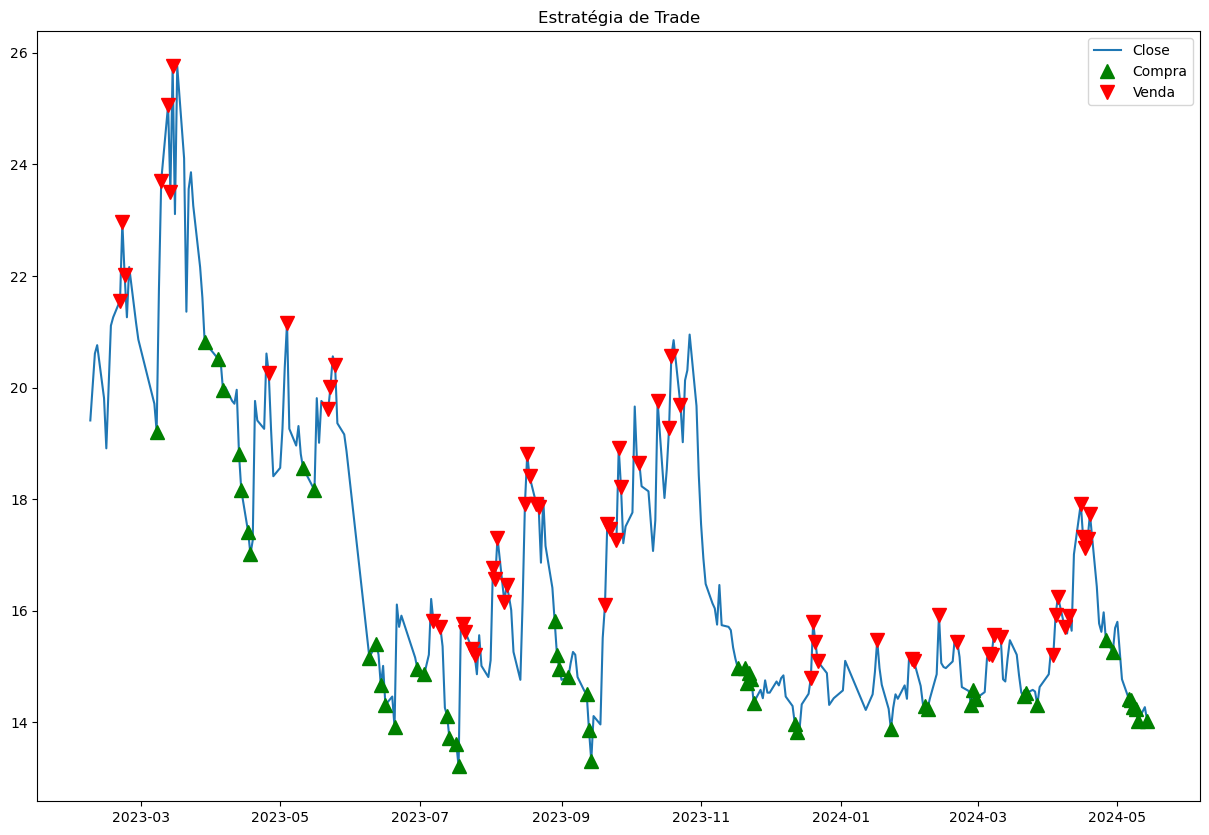

C:\Users\camps pro\AppData\Local\Temp\ipykernel_18724\3032028034.py:45: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g["Retorno10"] = g["Close"].pct_change(4)*100
C:\Users\camps pro\AppData\Local\Temp\ipykernel_18724\3032028034.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g["Alvo10"] = g["Retorno10"].shift(-4)
C:\Users\camps pro\AppData\Local\Temp\ipykernel_18724\3032028034.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

retorno 433.41951997610124
acerto 83
erro 40
acuracia 0.6747967479674797
total de trades 123
total de dias 324
retorno acumulado em % nan
retorno medio do acerto 1.3502165731342717
retorno medio do erro -4.135960904949472
retorno medio do acerto 6.966001827100394
stop loss recomendado de: - 6.447999899775447
Compre


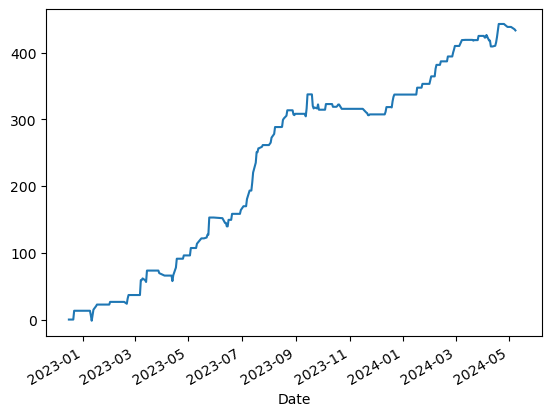

In [5]:
import MetaTrader5 as mt5
import datetime as dt
import pytz
timezone = pytz.timezone("Etc/UTC")
timezone
today = dt.datetime.now()
def padrao(df):
    df.rename(columns={'time':'Date', 'open':'Open', 'high':'High','low':'Low','close':'Close'}, inplace=True)
    df.drop(['tick_volume','spread','real_volume'], axis=1, inplace=True)
    df.set_index('Date', inplace=True)
    return df



ativos = ["USDJPY","USDCAD", "EURUSD", "GBPUSD",'XAUUSD','VIXY.ETF','VIX']
ativo = ativos[-1]
mt5.initialize()

g = mt5.copy_rates_from(ativo, mt5.TIMEFRAME_D1, today, 1000)
g = pd.DataFrame(g)
g['time'] = pd.to_datetime(g['time'], unit='s')
padrao(g)
var(g)
rede(g)


pesquisa = g.copy()


g['decisao'] = np.where((g['rede'] == 1) &  (g['rsi'] <30) &  (g['RSL20'].shift(1) <0), 1, 
                        np.where(((g['rede'] == 0)& (g['rsi']>65)&  (g['RSL20'].shift(1)>0)), -1, 0))



#plotar um grafico das posicoes
plt.figure(figsize=(15,10))
plt.plot(g['Close'].iloc[-300:], label='Close')
plt.plot(g['Close'].iloc[-300:][g['decisao'] == 1].iloc[-300:], '^', markersize=10, color='g', lw=0, label='Compra')
plt.plot(g['Close'].iloc[-300:][g['decisao'] == -1].iloc[-300:], 'v', markersize=10, color='r', lw=0, label='Venda')
plt.title('Estratégia de Trade')
plt.legend()
#sublinhar o que é compra e o que é venda por um periodo de 3 dias apos o sinal

plt.show()
g["Retorno10"] = g["Close"].pct_change(4)*100
g["Alvo10"] = g["Retorno10"].shift(-4)
g['alvo_bin'] = np.where(g['Alvo10'] > 0, 1, 0)   
g['retorno'] = np.where(g['decisao'] == 1, g['Alvo10'], np.where(g['decisao'] == -1, -g['Alvo10'], 0))
#meta['retorno'] = np.where(meta['retorno'] <= -1, -1, meta['retorno'])
g['retorno_acumulado'] = g['retorno'].cumsum()
g['retorno_acumulado'].plot()

acerto = 0
erro = 0
for i in range(len(g)):
    if (g['decisao'][i] == 1) & (g['alvo_bin'][i] == 1):
        acerto +=1
    elif (g['decisao'][i] == -1) & (g['alvo_bin'][i] == 0):
        acerto +=1
    elif (g['decisao'][i] == 1) & (g['alvo_bin'][i] == 0):
        erro +=1
    elif (g['decisao'][i] == -1) & (g['alvo_bin'][i] == 1):
        erro +=1
print('retorno', g['retorno'].sum())
print('acerto', acerto)
print('erro', erro)
print('acuracia', acerto/(acerto+erro))
print('total de trades', acerto+erro)
print('total de dias' , len(g))
print('retorno acumulado em %', g['retorno_acumulado'][-3])
print('retorno medio do acerto',  g['retorno'].mean())
print('retorno medio do erro',  g['retorno'][g['retorno'] < 0].mean())
print('retorno medio do acerto',  g['retorno'][g['retorno'] > 0].mean())
print('stop loss recomendado de: -', g['Retorno10'].rolling(60).std().tail(1).values[0] * 1.2)
if g['decisao'].iloc[-1] == 1:
    print('Compre')
elif g['decisao'].iloc[-1] == -1:
    print('Venda')
else:
    print('Fique de fora')

In [6]:
g.tail(10)

,Open,High,Low,Close,Retorno,delta,gain,loss,rsi,RSi_5,...,filtro7,var_venda,var_compra,rede,decisao,Retorno10,Alvo10,alvo_bin,retorno,retorno_acumulado
Date,,,,,,,,,,,,,,,,,,,,,
2024-05-01,15.86,16.13,15.12,15.80,0.007011,0.11,0.11,0.00,55.625000,29.961989,...,0,0,0,0,0,-1.064496,-8.924051,0,0.000000,438.639859
2024-05-02,15.70,15.88,15.23,15.28,-0.032911,-0.52,0.00,0.52,30.508475,26.354901,...,0,-1,0,1,0,-1.228184,-6.609948,0,0.000000,438.639859
2024-05-03,15.16,15.21,14.67,14.77,-0.033377,-0.51,0.00,0.51,30.337079,27.161503,...,0,0,0,1,0,-3.211009,-3.656060,0,0.000000,438.639859
2024-05-06,14.76,14.81,14.42,14.42,-0.023697,-0.35,0.00,0.35,28.125000,28.050425,...,1,0,1,1,1,-8.094328,-2.704577,0,-2.704577,435.935282
2024-05-07,14.39,14.49,14.32,14.39,-0.002080,-0.03,0.00,0.03,7.236842,27.392617,...,1,0,1,1,1,-8.924051,-0.833912,0,-0.833912,435.101370
2024-05-08,14.38,14.47,14.26,14.27,-0.008339,-0.12,0.00,0.12,0.000000,24.867871,...,1,0,1,1,1,-6.609948,-1.681850,0,-1.681850,433.419520
2024-05-09,14.29,14.41,14.23,14.23,-0.002803,-0.04,0.00,0.04,0.000000,25.315005,...,1,0,1,1,1,-3.656060,NaN,0,NaN,NaN
2024-05-10,14.23,14.24,14.02,14.03,-0.014055,-0.20,0.00,0.20,0.000000,24.815911,...,1,0,1,1,1,-2.704577,NaN,0,NaN,NaN
2024-05-13,14.10,14.32,13.98,14.27,0.017106,0.24,0.24,0.00,38.095238,22.430897,...,1,-1,0,1,0,-0.833912,NaN,0,0.000000,433.419520


In [7]:
g[g['var_venda']==-1]

,Open,High,Low,Close,Retorno,delta,gain,loss,rsi,RSi_5,...,filtro7,var_venda,var_compra,rede,decisao,Retorno10,Alvo10,alvo_bin,retorno,retorno_acumulado
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-20,22.16,23.01,21.21,21.41,-0.036020,-0.80,0.00,0.80,46.590909,48.523286,...,-1,-1,0,1,0,NaN,9.107894,1,0.000000,0.000000
2023-01-09,22.01,22.56,21.76,22.36,0.013599,0.30,0.30,0.00,25.000000,30.633597,...,1,-1,0,0,0,-2.400698,-13.640429,0,0.000000,13.190437
2023-01-20,21.50,21.76,20.81,20.91,-0.029698,-0.64,0.00,0.64,62.886598,25.804107,...,-1,-1,0,0,0,8.285862,-7.412721,0,0.000000,22.468097
2023-01-23,20.96,21.06,20.61,20.71,-0.009565,-0.20,0.00,0.20,70.114943,31.283031,...,-1,-1,0,1,0,5.340793,-9.898600,0,0.000000,22.468097
2023-01-24,20.66,20.96,19.81,19.91,-0.038629,-0.80,0.00,0.80,53.180662,36.099949,...,-1,-1,0,1,0,2.312436,-1.757911,0,0.000000,22.468097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,15.62,15.70,15.37,15.47,-0.031309,-0.50,0.00,0.50,11.824324,43.421843,...,0,-1,0,1,1,-5.842970,-1.228184,0,-1.228184,441.850869
2024-04-29,15.50,15.54,15.13,15.26,-0.013575,-0.21,0.00,0.21,18.716578,36.709032,...,0,-1,0,1,1,-3.233989,-3.211009,0,-3.211009,438.639859
2024-05-02,15.70,15.88,15.23,15.28,-0.032911,-0.52,0.00,0.52,30.508475,26.354901,...,0,-1,0,1,0,-1.228184,-6.609948,0,0.000000,438.639859
